In [289]:
import os
import pandas as pd
from typing import List
import pickle
import tushare as ts
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module="matplotlib")    
warnings.filterwarnings("ignore", module="pandas")    

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("[INFO] tushare version: {}".format(ts.__version__))
ts.set_token("76e92aefdcac82bf64da67564bd78d8871fcfb5659a48e8a7e779875")
pro = ts.pro_api()

[INFO] tushare version: 1.2.89


# Q3
![](Q3.jpg)

## 1
步骤：<br>
（1）. 筛选出上市日期在2015年之前的银行股<br>
（2）. 从（1）中返回的股票代码列表中，选出股票代码最大的10支股票代码<br>
（3）. 获取该10支股票代码从2015-2021年的日线行情数据

In [60]:
_data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
_stock_code_list = _data[(_data["industry"] == "银行") & (_data["list_date"] < '20150101')]["ts_code"].tolist()
_stock_code_dict = {int(_code.split(".")[0]): _code for _code in _stock_code_list}

ten_biggist_stock_codes_list = []
for _, _code in sorted(_stock_code_dict.items(), key=lambda x: x[0], reverse=True)[:10]:
    ten_biggist_stock_codes_list.append(_code)
print("[INFO] 上市日期在2015年之前的银行股中，股票代码最大的10支股票代码：\n{}".format(", ".join(ten_biggist_stock_codes_list)))

if not os.path.exists("10bank_daily_df.pkl"):
    print("[INFO] 10支股票日线数据未保存，重新下载 ...")
    ten_bank_stock_daily_data = defaultdict(pd.DataFrame)
    for _code in ten_biggist_stock_codes_list:
        ten_bank_stock_daily_data[_code] = pro.daily(ts_code=_code, start_date='20150101', end_date='20211231')
    
    file = open('10bank_daily_df.pkl','wb')
    pickle.dump(ten_bank_stock_daily_data, file)
    file.close()
    print("[INFO] 将10支股票日线数据保存本地 10bank_daily_df.pkl 文件 ...")
else:
    print("[INFO] 直接加载本地已保存的10支股票日线数据（10bank_daily_df.pkl 文件）...")
    file = open('10bank_daily_df.pkl','rb')
    ten_bank_stock_daily_data = pickle.load(file)
    file.close()

[INFO] 上市日期在2015年之前的银行股中，股票代码最大的10支股票代码：
601998.SH, 601988.SH, 601939.SH, 601818.SH, 601398.SH, 601328.SH, 601288.SH, 601169.SH, 601166.SH, 601009.SH
[INFO] 直接加载本地已保存的10支股票日线数据 10bank_daily_df.pkl 文件 ...


## 2
步骤：<br>
（1）. 将10支股票的close按照trade_date连接，合并成一个DataFrame<br>
（2）. 合并后表中的nan值填充为前一天的收盘价

In [196]:
if not os.path.exists("10bank_merged_close_df.pkl"):
    ten_bank_close_data = defaultdict(pd.DataFrame)
    max_trade_date_list = []
    for _code in ten_bank_stock_daily_data:
        ten_bank_close_data[_code] = ten_bank_stock_daily_data[_code].copy().get(["trade_date", "close"])
        ten_bank_close_data[_code].rename(columns={"close": _code}, inplace=True)
        ten_bank_close_data[_code].set_index("trade_date", inplace=True)
        if ten_bank_close_data[_code].shape[0] > len(max_trade_date_list):
            max_trade_date_list = ten_bank_close_data[_code].index.tolist()
    
    # 合并数据
    merged_close_data = pd.DataFrame(columns=list(ten_bank_stock_daily_data.keys()), index=max_trade_date_list[::-1])
    for _trade_date, row in merged_close_data.iterrows():
        for _code in row.keys():
            if _trade_date in ten_bank_close_data[_code].index:
                row[_code] = ten_bank_close_data[_code].loc[_trade_date].values[0]
    
    # 处理nan值
    L = merged_close_data.shape[0]
    for _code in merged_close_data.keys():
        if pd.isnull(merged_close_data[_code]).any():
            for _id in range(L):
                if _id > 0 and pd.isnull(merged_close_data[_code].iloc[_id]):
                    merged_close_data[_code].iloc[_id] = merged_close_data[_code].iloc[_id-1]
    
    
    file = open('10bank_merged_close_df.pkl','wb')
    pickle.dump(merged_close_data, file)
    file.close()
    print("[INFO] 将10支股票的close按照trade_date连接，合并成一个DataFrame保存本地 10bank_merged_close_df.pkl 文件 ...")
else:
    print("[INFO] 直接加载合并后的10支股票日线收盘价DataFrame数据（10bank_merged_close_df.pkl 文件）...")
    file = open('10bank_merged_close_df.pkl','rb')
    merged_close_data = pickle.load(file)
    file.close()

[INFO] 直接加载合并后的10支股票日线收盘价DataFrame数据（10bank_merged_close_df.pkl 文件）...


## 3 
步骤：<br>
（1）. 计算10支股票收益率序列<br>
（2）. 计算相关矩阵<br>
（3）. 绘制热图<br>

In [208]:
# 计算10支股票收益率序列
profit_rate_df = merged_close_data.pct_change().dropna()
profit_rate_df.head()

,601998.SH,601988.SH,601939.SH,601818.SH,601398.SH,601328.SH,601288.SH,601169.SH,601166.SH,601009.SH
20150106,-0.028186,0.031674,-0.014451,-0.018293,0.007905,-0.021277,0.015424,-0.019039,0.007113,-0.020394
20150107,-0.002522,-0.004386,-0.027859,-0.014493,-0.011765,-0.020290,-0.015190,-0.020333,-0.022366,-0.013185
20150108,-0.046776,-0.046256,-0.042232,-0.044118,-0.041667,-0.034024,-0.041131,-0.032075,-0.042143,-0.036568
20150109,0.007958,0.032333,0.007874,0.010989,0.010352,-0.004594,0.008043,0.044834,0.016970,0.010949
20150112,-0.018421,-0.015660,-0.023438,-0.017391,-0.012295,-0.003077,-0.023936,0.020522,-0.009271,-0.026715


In [207]:
# 计算相关矩阵
corr_mat = profit_rate_df.corr()
corr_mat

,601998.SH,601988.SH,601939.SH,601818.SH,601398.SH,601328.SH,601288.SH,601169.SH,601166.SH,601009.SH
601998.SH,1.000000,0.750981,0.709620,0.753185,0.659264,0.715438,0.704921,0.572542,0.657623,0.517517
601988.SH,0.750981,1.000000,0.790890,0.757245,0.794688,0.780075,0.821418,0.575869,0.636854,0.478922
601939.SH,0.709620,0.790890,1.000000,0.761937,0.838592,0.761662,0.831302,0.579575,0.710989,0.562876
601818.SH,0.753185,0.757245,0.761937,1.000000,0.708452,0.794767,0.749235,0.614211,0.743768,0.558669
601398.SH,0.659264,0.794688,0.838592,0.708452,1.000000,0.742598,0.832765,0.543338,0.655199,0.492340
601328.SH,0.715438,0.780075,0.761662,0.794767,0.742598,1.000000,0.770855,0.634117,0.692786,0.524968
601288.SH,0.704921,0.821418,0.831302,0.749235,0.832765,0.770855,1.000000,0.569986,0.672466,0.503354
601169.SH,0.572542,0.575869,0.579575,0.614211,0.543338,0.634117,0.569986,1.000000,0.625880,0.494002
601166.SH,0.657623,0.636854,0.710989,0.743768,0.655199,0.692786,0.672466,0.625880,1.000000,0.598144
601009.SH,0.517517,0.478922,0.562876,0.558669,0.492340,0.524968,0.503354,0.494002,0.598144,1.000000


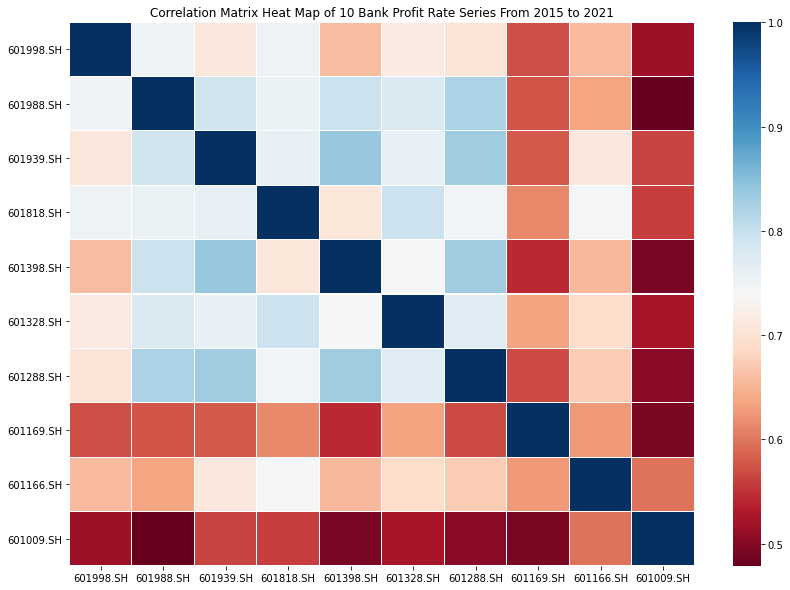

In [217]:
# 绘制热图
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (14, 10))
sns.heatmap(corr_mat, cmap='RdBu', linewidths=0.05)

plt.title('Correlation Matrix Heat Map of 10 Bank Profit Rate Series From 2015 to 2021')
plt.show()
plt.close()

f.savefig('corr_mat_heatmap.jpg', dpi=100, bbox_inches='tight')

## 4
![](Q3.jpg)

In [265]:
merged_close_data.head()

,601998.SH,601988.SH,601939.SH,601818.SH,601398.SH,601328.SH,601288.SH,601169.SH,601166.SH,601009.SH
20150105,8.16,4.42,6.92,4.92,5.06,7.05,3.89,11.03,16.87,14.71
20150106,7.93,4.56,6.82,4.83,5.1,6.9,3.95,10.82,16.99,14.41
20150107,7.91,4.54,6.63,4.76,5.04,6.76,3.89,10.6,16.61,14.22
20150108,7.54,4.33,6.35,4.55,4.83,6.53,3.73,10.26,15.91,13.7
20150109,7.6,4.47,6.4,4.6,4.88,6.5,3.76,10.72,16.18,13.85


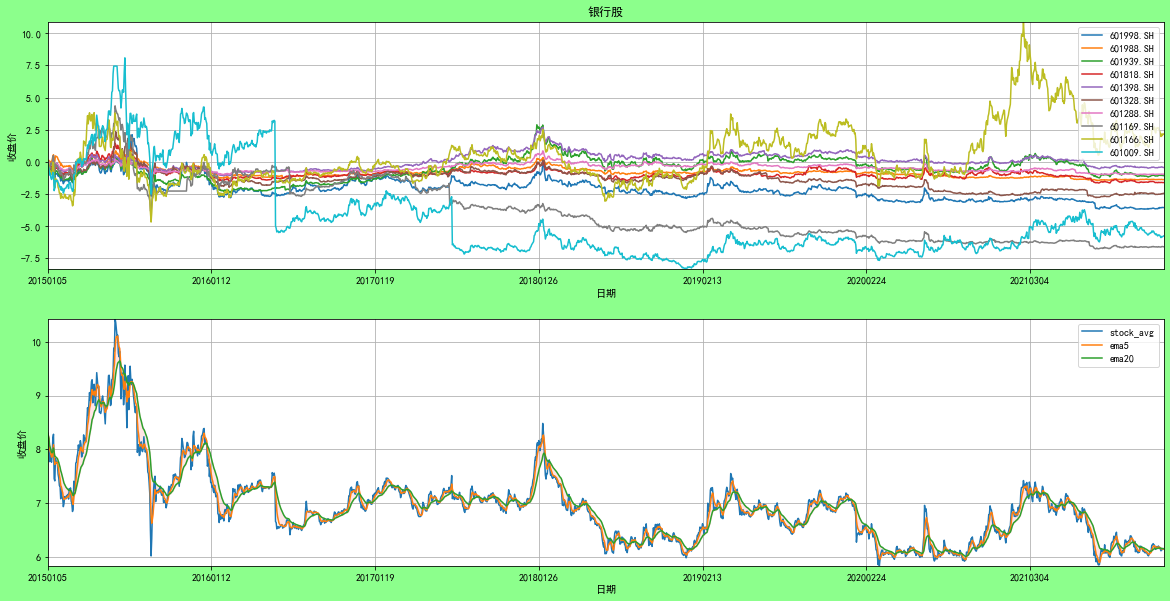

In [309]:
fig = plt.figure(figsize=(20, 10), facecolor='#8cff8c')
ax = fig.add_subplot(2,1,1)
ax = (merged_close_data - merged_close_data.iloc[0]).plot(ax=ax, title="银行股", fontsize=10, grid=True)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
plt.margins(0, 0)

ax = fig.add_subplot(2,1,2)
stock_avg = merged_close_data.mean(axis=1)  # 计算stock_avg
ema5 = pd.DataFrame.ewm(stock_avg, span=5).mean()  # 计算ema5
ema20 = pd.DataFrame.ewm(stock_avg, span=20).mean()  # 计算ema20

stock_avg.plot(ax=ax, grid=True)
ema5.plot(ax=ax, grid=True)
ema20.plot(ax=ax, grid=True)

ax.fill_between(stock_avg.index, ema5, ema20, color="r", alpha=0.1)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
ax.legend(["stock_avg", "ema5", "ema20"])
plt.margins(0, 0)

plt.show()

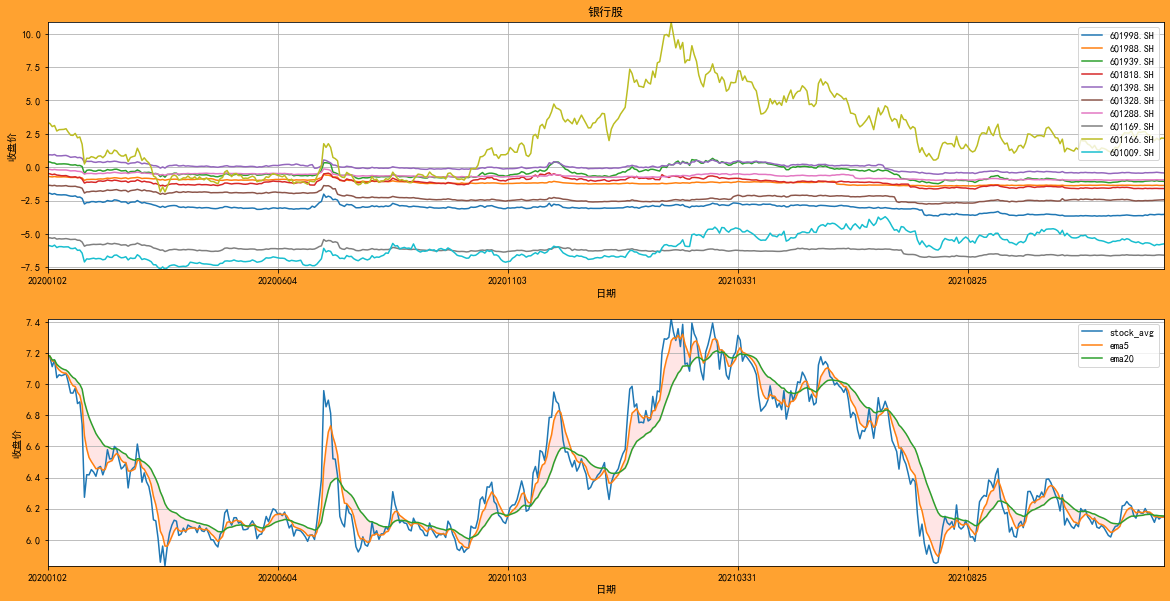

In [374]:
# 选 2020-01-01 至 2021-12-31 进行放大观察细节
fig = plt.figure(figsize=(20, 10), facecolor='#ffa230')
ax = fig.add_subplot(2,1,1)
ax = (merged_close_data - merged_close_data.iloc[0])['20200101':'20211231'].plot(ax=ax, title="银行股", fontsize=10, grid=True)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
plt.margins(0, 0)

ax = fig.add_subplot(2,1,2)
stock_avg = merged_close_data.mean(axis=1)['20200101':'20211231']  # 计算stock_avg
ema5 = pd.DataFrame.ewm(stock_avg, span=5).mean()  # 计算ema5
ema20 = pd.DataFrame.ewm(stock_avg, span=20).mean()  # 计算ema20

stock_avg.plot(ax=ax, grid=True)
ema5.plot(ax=ax, grid=True)
ema20.plot(ax=ax, grid=True)

ax.fill_between(stock_avg.index, ema5, ema20, color="r", alpha=0.1)
ax.set_ylabel("收盘价")
ax.set_xlabel('日期')
ax.legend(["stock_avg", "ema5", "ema20"])
plt.margins(0, 0)

plt.show()

# Q4
![](Q4.jpg)

## 1

In [372]:
# 计算最大回撤(%)
def getMaxDrawdown(x):
    j = np.argmax((np.maximum.accumulate(x) - x) / x)
    if j == 0:
        return 0
    i = np.argmax(x[:j])
    d = (x[i] - x[j]) / x[i] * 100
    return d

# 计算夏普比率(%)
def getSharpRatio(x):
    x = x.pct_change(1)  # 日均收益
    R = x.cumsum()  # 累积收益
    r = (R - R.shift(1)) / R.shift(1)
    sr = r.mean() / r.std() * np.sqrt(252) * 100
    return sr

# # 计算年平均收益率(%)
def getAvgReturnRatio(x):
    x = x.pct_change(1)  # 日均收益
    mean_return_daily = np.mean(x) # 日平均收益
    mean_return_annualized = ((1 + mean_return_daily)**252) - 1  # 计算平均年化收益

    return mean_return_annualized * 100

# def getAvgReturnRatio(x):
#     annual_profit_rate = x.pct_change()
#     r_daily_mean = ((1+annual_profit_rate).prod())**(1/annual_profit_rate.shape[0])-1

#     return r_daily_mean


# def MaxDrawdown(return_list):
#     '''最大回撤率'''
#     i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
#     if i == 0:
#         return 0
#     j = np.argmax(return_list[:i])  # 开始位置
#     return (return_list[j] - return_list[i]) / (return_list[j])


stat_data = pd.DataFrame(columns=["股票代码", "夏普比率(%)", "最大回撤(%)", "平均收益率(%)"])
stat_data["股票代码"] = merged_close_data.keys()
for ind, row in stat_data.iterrows():
    row["最大回撤(%)"] = getMaxDrawdown(merged_close_data[row["股票代码"]])
    row["夏普比率(%)"] = getSharpRatio(merged_close_data[row["股票代码"]])
    row["平均收益率(%)"] = getAvgReturnRatio(merged_close_data[row["股票代码"]])

print("[INFO] 打印10支股票的夏普比率(%), 最大回撤(%)和年平均收益率(%)： ")
stat_data

[INFO] 打印10支股票的夏普比率(%), 最大回撤(%)和年平均收益率(%)： 


,股票代码,夏普比率(%),最大回撤(%),平均收益率(%)
0,601998.SH,31.0798,56.323,-4.21786
1,601988.SH,41.4004,46.7857,-2.85991
2,601939.SH,-0.9824,42.0999,0.983489
3,601818.SH,-43.8105,48.5893,-1.89352
4,601398.SH,31.1528,41.5484,1.17871
5,601328.SH,7.50534,54.4681,-3.22823
6,601288.SH,-30.4336,38.9474,-1.88529
7,601169.SH,-64.3157,72.1897,-9.26398
8,601166.SH,42.4975,41.0628,6.05417
9,601009.SH,-28.3258,72.0614,0.906584


## 2

In [393]:
print("夏普率和最大回撤率的相关系数：", stat_data['夏普比率(%)'].corr(stat_data['最大回撤(%)'], method="kendall"))
print("夏普率和平均收益率的相关系数：", stat_data['夏普比率(%)'].corr(stat_data['平均收益率(%)'], method="kendall"))
print("[INFO] 可见，夏普率和平均收益率存在一定的正相关性，而与最大回撤率存在一定的负相关性。")

夏普率和最大回撤率的相关系数： -0.3333333333333333
夏普率和平均收益率的相关系数： 0.37777777777777777
[INFO] 可见，夏普率和平均收益率存在一定的正相关性，而与最大回撤率存在一定的负相关性。


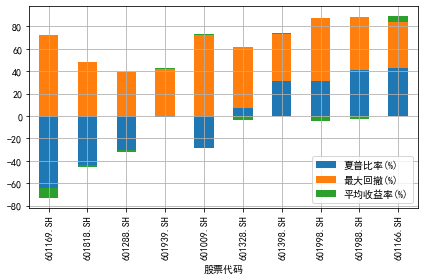

In [376]:
# 作堆叠柱状图观察分析
stat_data['Total'] = stat_data['夏普比率(%)'] + stat_data['最大回撤(%)'] + stat_data['平均收益率(%)']
# 生成一个总的中间变量，实现按照中间变量的降序排列，使得图形美观
stat_data.sort_values(by='Total', inplace=True, ascending=True)
 
stat_data.plot.bar(x='股票代码', y=['夏普比率(%)', '最大回撤(%)', '平均收益率(%)'], stacked=True, grid=True)
plt.tight_layout()
plt.show()

In [394]:
print("[INFO] 由上面的堆叠柱状图可以看到，'601166.SH'的夏普率和平均收益都是最大的，且最大回撤也是最小的，因此我会选择该支股票进行投资")

[INFO] 由上面的堆叠柱状图可以看到，'601166.SH'的夏普率和平均收益都是最大的，且最大回撤也是最小的，因此我会选择该支股票进行投资
